# A/B Testing Case Study

A/B tests are used to test changes on a web page by running an experiment where a control group sees the old version, while the experiment group sees the new version. A metric is then chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other.

In this case study, I’ll analyze A/B test results for Audacity.

Here's the customer funnel for typical new users on their site:
View home page > Explore courses > View course overview page > Enroll in course > Complete course

We’ll analyze test results for two changes they have in mind, and then make a recommendation on whether they should launch each change.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ab-testing-case-study/course_page_actions.csv
/kaggle/input/ab-testing-case-study/classroom_actions.csv
/kaggle/input/ab-testing-case-study/homepage_actions.csv


# Experiment 1

The first change Audacity wants to try is on their homepage. They hope that this new, more engaging design will increase the number of users that explore their courses, that is, move on to the second stage of the funnel.

In [31]:
df = pd.read_csv('/kaggle/input/ab-testing-case-study/homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [32]:
df.shape

(8188, 4)

In [33]:
df.nunique()

timestamp    8188
id           6328
group           2
action          2
dtype: int64

In [34]:
df.groupby('group').nunique()

,timestamp,id,action
group,,,
control,4264,3332,2
experiment,3924,2996,2


In [35]:
df.action.value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [36]:
df.query('action == "click"').id.nunique() / df.query('action == "view"').id.nunique()

0.2939317319848293

In [37]:
df.timestamp.max(), df.timestamp.min()

('2017-01-18 10:24:08.629327', '2016-09-24 17:42:27.839496')

# Experiment 2

The second change Audacity is A/B testing is a more career focused description on a course overview page. They hope that this change may encourage more users to enroll and complete this course. In this experiment, we’re going to analyze the following metrics:

* Enrollment Rate: Click through rate for the Enroll button the course overview page
* Average Reading Duration: Average number of seconds spent on the course overview page
* Average Classroom Time: Average number of days spent in the classroom for students enrolled in the course
* Completion Rate: Course completion rate for students enrolled in the course

First, let's determine if the difference observed for each metric is statistically significant individually.

### **Enrollment Rate**

In [2]:
df = pd.read_csv('/kaggle/input/ab-testing-case-study/course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [3]:
#get dataframe with all records from control group
control_df = df.query('group == "control"')

#compute click through rate for control group
control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()

#display click through rate
control_ctr

0.2364438839848676

In [4]:
#get dataframe with all records from experiment group
experiment_df = df.query('group == "experiment"')

#compute click through rate for experiment group
experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()

#display click through rate
experiment_ctr

0.2668693009118541

In [5]:
#compute the observed difference in click through rates
obs_diff = experiment_ctr - control_ctr

#display observed differnce
obs_diff

0.030425416926986526

In [6]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)

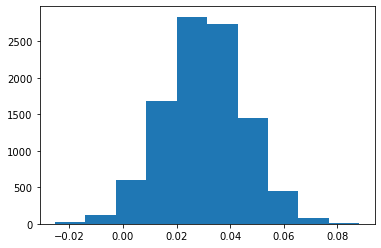

In [7]:
#convert to numpy array
diffs = np.array(diffs)

#plot sampling distributions
plt.hist(diffs);

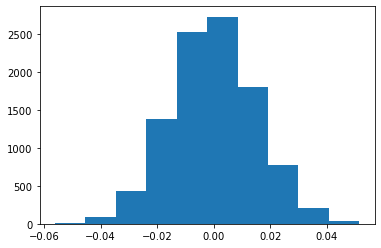

In [8]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# Plot the null distribution
plt.hist(null_vals);

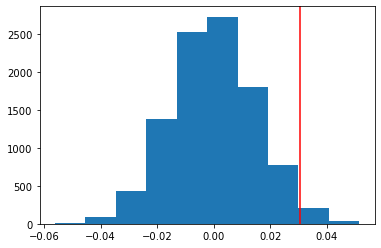

In [9]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);

plt.axvline(obs_diff,c='r');

In [10]:
# Compute p-value
(null_vals > obs_diff).mean()

0.0224

### **Average classroom time**

In [11]:
df = pd.read_csv('/kaggle/input/ab-testing-case-study/classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [12]:
# The total_days represents the total amount of time
# each student has spent in classroom.
# get the average classroom time for control group
control_mean = df.query('group == "control"')["total_days"].mean()

# get the average classroom time for experiment group
experiment_mean = df.query('group == "experiment"')["total_days"].mean()

# display average classroom time for each group
control_mean, experiment_mean

(73.36899038461539, 74.6715935334873)

In [13]:
# compute observed difference in classroom time
obs_diff = experiment_mean - control_mean

# display observed difference
obs_diff

1.3026031488719099

In [14]:
# create sampling distribution of difference in average classroom times
# with boostrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_mean = b_samp.query('group == "control"').total_days.mean()
    experiment_mean = b_samp.query('group == "experiment"').total_days.mean()
    diffs.append(experiment_mean-control_mean)

In [15]:
# convert to numpy array
diffs = np.array(diffs)

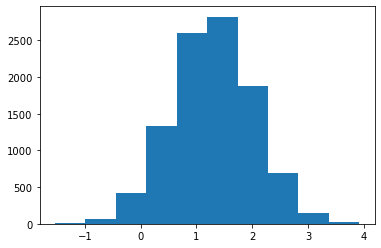

In [16]:
# plot sampling distribution
plt.hist(diffs);

In [17]:
# simulate distribution under the null hypothesis/
null_vals = np.random.normal(0,diffs.std(), diffs.size)

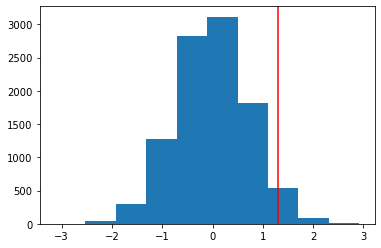

In [18]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red');

In [19]:
# compute p value
(null_vals > obs_diff).mean()

0.034

## Completion Rate


In [21]:
df = pd.read_csv('/kaggle/input/ab-testing-case-study/classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [22]:
# Create dataframe with all control records
control_df = df.query('group == "control"')

# Compute completion rate
control_cr =  control_df['completed'].mean() 

# Display completion rate
control_cr

0.3719951923076923

In [23]:
# Create dataframe with all experiment records
experiment_df = df.query('group=="experiment"')

# Compute completion rate
experiment_ctr = experiment_df['completed'].mean()

# Display completion rate
experiment_ctr

0.3935334872979215

In [24]:
# Compute observed difference in completion rates
obs_diff = experiment_ctr - control_cr

# Display observed difference in completion rates
obs_diff

0.02153829499022919

In [25]:
# Create sampling distribution for difference in completion rates
# with boostrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    control_cr =  control_df['completed'].mean() 
    experiment_df = b_samp.query('group=="experiment"')
    experiment_ctr = experiment_df['completed'].mean()
    diffs.append(experiment_ctr - control_cr)

In [26]:
# convert to numpy array
diffs = np.array(diffs)

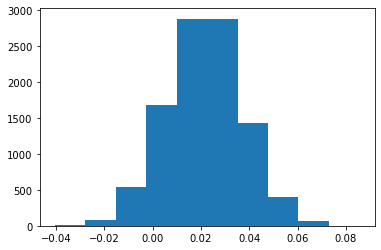

In [27]:
# plot distribution
plt.hist(diffs);

In [28]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), size)

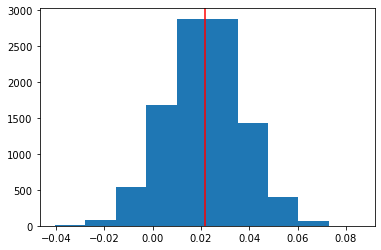

In [29]:
# plot null distribution
plt.hist(diffs);

# plot line for observed statistic
plt.axvline(obs_diff, c='red');

In [30]:
# compute p value
(null_vals > obs_diff).mean()

0.08461739357534605

## Difficulties in A/B Testing
* Novelty effect and change aversion
* Sufficient traffic and conversions to have significant and repeatable results
* Best metric choice for making the ultimate decision 
* Long enough run time for the experiment to account for changes in behavior based on time of day/week or seasonal events.
* Practical significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion)
* Consistency among test subjects in the control and experiment group (imbalance in the population represented in each group can lead to situations like Simpson's Paradox)